<a href="https://colab.research.google.com/github/roshan-varadhan/spotify-playlist-recommender/blob/main/spotify_playlist_recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Importing Libraries**

In [ ]:
!pip install spotipy
!pip install python-dotenv

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time
import os
from dotenv import load_dotenv
from pathlib import Path

# Connecting to Spotify

In [ ]:
#Authentication
load_dotenv(dotenv_path=Path('/content/variables.env'))
cid = os.getenv('CLIENT_ID')
secret = os.getenv('CLIENT_SECRET')

if cid is None or secret is None:
    raise ValueError(
        "Spotify client ID or secret not found. "
        "Make sure you have set the SPOTIPY_CLIENT_ID and SPOTIPY_CLIENT_SECRET "
        "environment variables or have a valid .env file."
    )

client_credentials_mgmt = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_mgmt)

## Playlist Dataframe

In [ ]:
playlist_link = input("Enter the playlist link: ")

# Extract playlist URI from the link
playlist_URI = playlist_link.split("/")[-1].split("?")[0]

# Function to handle retries
def fetch_with_retry(func, *args, retries=5, delay=1, backoff=2, **kwargs):
    for i in range(retries):
        try:
            return func(*args, **kwargs)
        except spotipy.exceptions.SpotifyException as e:
            if e.http_status == 429:
                retry_after = int(e.headers.get('Retry-After', delay))
                print(f"Rate limited. Retrying in {retry_after} seconds...")
                time.sleep(retry_after)
                delay *= backoff
            else:
                raise e
    raise Exception("Max retries exceeded")

# Fetch playlist details
playlist_details = fetch_with_retry(sp.playlist, playlist_URI)

# Get playlist name and user display name
playlist_name = playlist_details['name']
user_display_name = playlist_details['owner']['display_name']

# Fetch playlist tracks
tracks = fetch_with_retry(sp.playlist_tracks, playlist_URI)["items"]

# Extract track details
track_uris = [item["track"]["uri"] for item in tracks]

# Batch URIs for audio features
def get_audio_features(track_uris):
    audio_features = []
    for i in range(0, len(track_uris), 100):
        batch = track_uris[i:i+100]
        features = fetch_with_retry(sp.audio_features, batch)
        audio_features.extend(features)
    return audio_features

# Fetch audio features for the tracks
audio_features = get_audio_features(track_uris)

# Combine track details with audio features
track_data = []
for item, features in zip(tracks, audio_features):
    if features:
      track = item["track"]
      track_name = track["name"]
      artist_name = track["artists"][0]["name"]  # Assuming the first artist is the main artist
      track_uri = track["uri"]

      # Fetch audio features for the track
      audio_features = sp.audio_features(track_uri)[0]
      danceability = audio_features['danceability']
      energy = audio_features['energy']
      liveliness = audio_features['liveness']
      key = audio_features['key']
      mode = audio_features['mode']
      loudness = audio_features['loudness']
      speechiness = audio_features['speechiness']
      acousticness = audio_features['acousticness']
      instrumentalness = audio_features['instrumentalness']
      valence = audio_features['valence']

      track_data.append([track_name, artist_name, danceability, energy, liveliness, key, mode, loudness, speechiness, acousticness, instrumentalness, valence])

# Create a DataFrame
df_playlist = pd.DataFrame(track_data, columns=["Track Name", "Artist", "Danceability", "Energy", "Liveliness","Key","Mode","Loudness","Speechiness","Acousticness","Instrumentalness","Valence"])
df_playlist.head()

ERROR:spotipy.client:Max Retries reached


Rate limited. Retrying in 1 seconds...


ERROR:spotipy.client:Max Retries reached


Rate limited. Retrying in 2 seconds...


ERROR:spotipy.client:Max Retries reached


Rate limited. Retrying in 4 seconds...


ERROR:spotipy.client:Max Retries reached


Rate limited. Retrying in 8 seconds...


ERROR:spotipy.client:Max Retries reached


Rate limited. Retrying in 16 seconds...


Exception: Max retries exceeded

## Loading the Data into a Pandas DataFrame

In [ ]:
df = pd.read_csv("playlist_2010to2023.csv", encoding='latin-1')
df.dropna(inplace=True)
# Drop Unnecessary Columns
df.drop(['year','artist_genres','playlist_url','track_id','track_popularity','artist_id','artist_popularity','time_signature', 'duration_ms'], axis=1, inplace=True)
df.head()


,track_name,album,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Oops!...I Did It Again,Oops!... I Did It Again,Britney Spears,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053
1,All The Small Things,Enema Of The State,blink-182,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726
2,Breathe,Breathe,Faith Hill,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859
3,It's My Life,Crush,Bon Jovi,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992
4,Bye Bye Bye,No Strings Attached,*NSYNC,0.610,0.926,8,-4.843,0,0.0479,0.0310,0.001200,0.0821,0.861,172.638


## Dropping Features and Combining Data

In [ ]:
# Create a new DataFrame with only necessary columns
dropped_df = df[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']]


# Congregate playlist averages into one representative 'song' to be used for comparison
dropped_df_playlist = dropped_df.drop(['Track Name', 'Artist'])
means= dropped_df_playlist.mean()
dropped_df.loc[len(dropped_df.index)] = means
df.loc[len(df.index)] = [playlist_name,'', user_display_name, means['danceability'], means['energy'], means['key'], means['loudness'], means['mode'], means['speechiness'], means['acousticness'], means['instrumentalness'], means['liveness'], means['valence'], means['tempo']]

KeyError: "['Track Name', 'Artist'] not found in axis"

In [ ]:
# Normalizing numerical feature columns
numerical_columns = ['loudness', 'tempo','key']

# Create a copy of the dropped_df
final_df = dropped_df

# Apply min-max scaling to the selected numerical feature columns
final_df[numerical_columns] = (dropped_df[numerical_columns] - dropped_df[numerical_columns].min()) / (dropped_df[numerical_columns].max() - dropped_df[numerical_columns].min())
final_df

<ipython-input-36-4c14cbc0b816>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[numerical_columns] = (dropped_df[numerical_columns] - dropped_df[numerical_columns].min()) / (dropped_df[numerical_columns].max() - dropped_df[numerical_columns].min())


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.751000,0.834000,0.090909,0.751908,0.000000,0.043700,0.300000,0.000018,0.355000,0.894000,0.232262
1,0.434000,0.897000,0.000000,0.777159,1.000000,0.048800,0.010300,0.000000,0.612000,0.684000,0.588095
2,0.529000,0.496000,0.636364,0.580865,1.000000,0.029000,0.173000,0.000000,0.251000,0.278000,0.509421
3,0.551000,0.913000,0.000000,0.818204,0.000000,0.046600,0.026300,0.000013,0.347000,0.544000,0.397599
4,0.610000,0.926000,0.727273,0.780759,0.000000,0.047900,0.031000,0.001200,0.082100,0.861000,0.746622
...,...,...,...,...,...,...,...,...,...,...,...
2396,0.842000,0.756000,0.636364,0.657578,0.000000,0.338000,0.525000,0.000002,0.087100,0.421000,0.728636
2397,0.662000,0.398000,1.000000,0.692046,0.000000,0.027500,0.716000,0.000000,0.111000,0.468000,0.311473
2398,0.787000,0.686000,0.545455,0.803466,0.000000,0.033900,0.089300,0.000000,0.092700,0.836000,0.420922
2399,0.759000,0.567000,0.181818,0.633479,1.000000,0.248000,0.118000,0.027800,0.105000,0.421000,0.185378


# Data Analyzation

## Clustering the Data

In [ ]:
# Function that works out optimum number of clusters
def optimise_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, n_init=max_k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    # Generate the elbow plot
    plt.figure(figsize=(10, 5))  # Create a new figure
    plt.plot(means, inertias, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

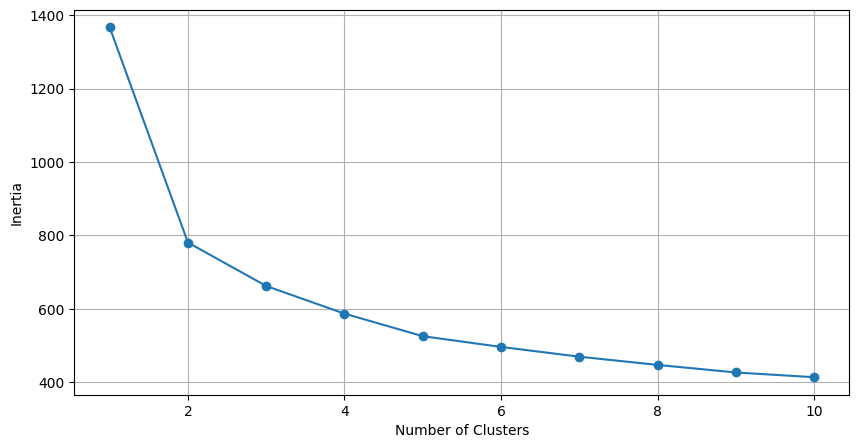

In [ ]:
optimise_k_means(final_df, 10)

## Applying K-Means Clustering

In [ ]:
# Initialize a KMeans model with 4 clusters
kmeans = KMeans(n_clusters=10, n_init='auto')

# Fit the KMeans model to the data in 'final_df'
kmeans.fit(final_df)

# Assign cluster labels to each data point and add the 'Cluster' column to the original DataFrame
df['Cluster'] = kmeans.labels_
final_df['Cluster'] = kmeans.labels_

<ipython-input-38-c34dd9709eb8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Cluster'] = kmeans.labels_


## Model Visualization

<ipython-input-39-298cb5ff5d61>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['pca_1'] = reduced_features[:, 0]
<ipython-input-39-298cb5ff5d61>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['pca_2'] = reduced_features[:, 1]


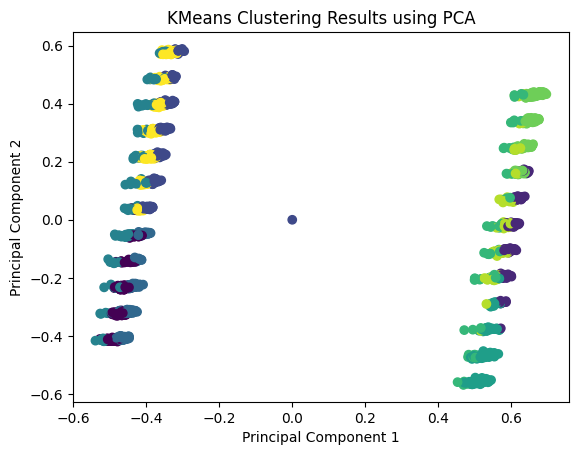

In [ ]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(final_df.drop('Cluster', axis=1)) # Exclude the cluster labels

# Add the reduced components to the DataFrame
final_df['pca_1'] = reduced_features[:, 0]
final_df['pca_2'] = reduced_features[:, 1]

# Create a scatter plot
plt.scatter(final_df['pca_1'], final_df['pca_2'], c=final_df['Cluster'], cmap='viridis')
plt.title('KMeans Clustering Results using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Song Recommendations

In [ ]:
def find_song_recommendation(track_name, df):
    try:
        # Attempt to find the index of the first occurence of 'track_name' in the 'Track' column of 'df'
        track_index = df[df['track_name'] == track_name].index[0]

        # Create a filter to select rows in 'df' that belong to the same cluster as the provided track
        filter = (df['Cluster'] == df.loc[track_index]['Cluster'])

        # Apply the filter to 'df' to get a DataFrame containing songs from the same cluster
        filtered_df = df[filter]

        # Generate song recommendations by randomly selecting tracks from the same cluster
        for i in range(50):
            # Randomly sample a track from the shuffled DataFrame
            recommendation = filtered_df.sample()
            # Print the recommended track's title and artist
            print("'" + recommendation.iloc[0]['track_name'] + "' by " + recommendation.iloc[0]['artist_name'])
    except:
      print("Track not found in the dataset.")

In [ ]:
find_song_recommendation('Playlist Name', df)

'Dangerous' by Kardinal Offishall
'What Would You Do?' by City High
'Turn Me On' by Kevin Lyttle
'Monster' by Skillet
'Take Me To The Clouds Above - LMC Vs. U2 / Radio Edit' by LMC
'All Summer Long' by Kid Rock
'Supermassive Black Hole' by Muse
'You Sang To Me' by Marc Anthony
'Life is a Highway' by Rascal Flatts
'Blank Space' by Taylor Swift
'Excuse Me Miss' by JAY-Z
'Fill Me In' by Craig David
'She Wants To Move' by N.E.R.D
'Little Dark Age' by MGMT
'Please Don't Leave Me' by P!nk
'Supalonely (feat. Gus Dapperton)' by BENEE
'Hella Good' by No Doubt
'Through The Wire' by Kanye West
'That's the Way It Is' by Céline Dion
'Te Felicito' by Shakira
'Fast Car' by Luke Combs
'CUFF IT' by Beyoncé
'Come With Me - Radio Edit' by Special D.
'Your Body Is a Wonderland' by John Mayer
'My Boo' by USHER
'Firework' by Katy Perry
'Paint The Town Red' by Doja Cat
'The Tide Is High - Radio Mix' by Atomic Kitten
'I Need a Girl (Pt. 1) [feat. Usher & Loon]' by Diddy
'China' by Anuel AA
'Over My Head (Cabl